# Time series


La libreria `siphon` viene con un servicio de consulta especializado para series temporales.

In [97]:

from siphon.catalog import TDSCatalog

In [98]:
# si el catalogo que se desea es de 0.25 grados
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')

# lista de colecciones
print(best_gfs.datasets)

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [99]:
best_ds = list(best_gfs.datasets.values())[1]

# diccionario de urls disponibles con la información
best_ds.access_urls

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'JupyterNotebook': 'https://thredds.ucar.edu/thredds/notebook/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grid/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best'}

In [100]:
best_ds = best_gfs.datasets[0]
ncss =best_ds.subset()
query = ncss.query()

Requerimiento de datos

In [101]:
from datetime import datetime, timedelta, timezone

now = datetime.now(timezone.utc)
# buscando la posición de lima
query.lonlat_point(-77, -12).vertical_level(100000).time_range(now, now + timedelta(days=30))
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric')

# haciendo el requerimiento de los datos
data = ncss.get_data(query)

In [102]:
temp = data.variables['Temperature_isobaric']
relh = data.variables['Relative_humidity_isobaric']
tiempo = data.variables['time']

In [103]:
import numpy as np
from netCDF4 import num2date

# tenemos que ayudarnos con el numpy.array para trabajar con estos datos
time_vals = np.array(num2date(tiempo[:].squeeze(), tiempo.units), dtype='datetime64[s]')
time_vals[:5]

array(['2022-10-24T18:00:00', '2022-10-24T21:00:00',
       '2022-10-25T00:00:00', '2022-10-25T03:00:00',
       '2022-10-25T06:00:00'], dtype='datetime64[s]')

Vamos a dejar nuestros datos mas fáciles de manipular, utilizaremos el `xarray.backends`

> recuerda que los datos que vamos a utlizar son los que vienen del `data = ncss.get_data(query)`

In [104]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data_2 = xr.open_dataset(NetCDF4DataStore(data))
list(data.variables.keys())

['latitude',
 'longitude',
 'stationAltitude',
 'station_id',
 'station_description',
 'time',
 'stationIndex',
 'Temperature_isobaric',
 'Relative_humidity_isobaric']

## Plot normal

/tmp/ipykernel_263925/1729086785.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


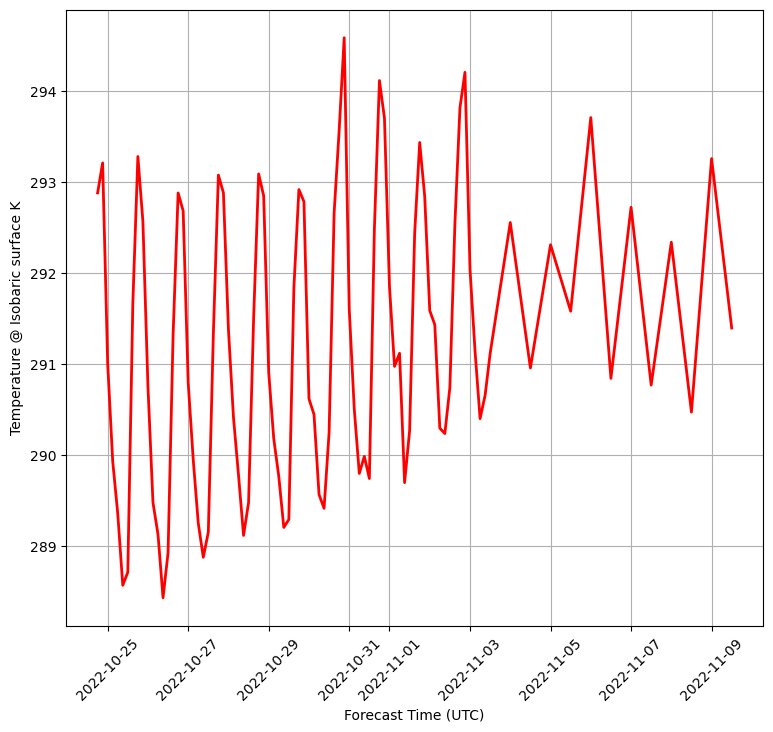

In [105]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel(f'{temp.long_name} {temp.units}')
ax.set_xlabel('Forecast Time (UTC)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(True)

/tmp/ipykernel_263925/528398502.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


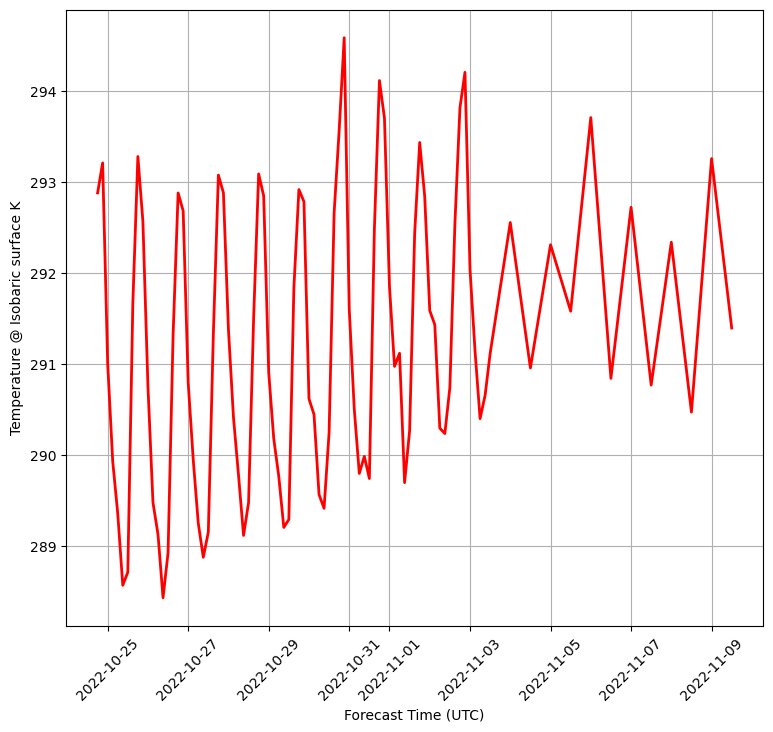

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(data_2.time, data_2.Temperature_isobaric, 'r', linewidth=2)
ax.set_ylabel(f'{data_2.Temperature_isobaric.long_name} {data_2.Temperature_isobaric.units}')
ax.set_xlabel('Forecast Time (UTC)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(True)

## Plot melhorado

Vamos a utilizar la base disponibilizada por el `geocat-viz` para [manipular los ejes](https://geocat-examples.readthedocs.io/en/latest/gallery/XY/NCL_tm_2.html#sphx-glr-gallery-xy-ncl-tm-2-py)

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import geocat.viz as gv


In [108]:
tiempo

<class 'netCDF4._netCDF4.Variable'>
float64 time(obs)
    units: Hour since 2022-10-24T12:00:00Z
    long_name: time of measurement
    calendar: proleptic_gregorian
unlimited dimensions: obs
current shape = (91,)
filling off

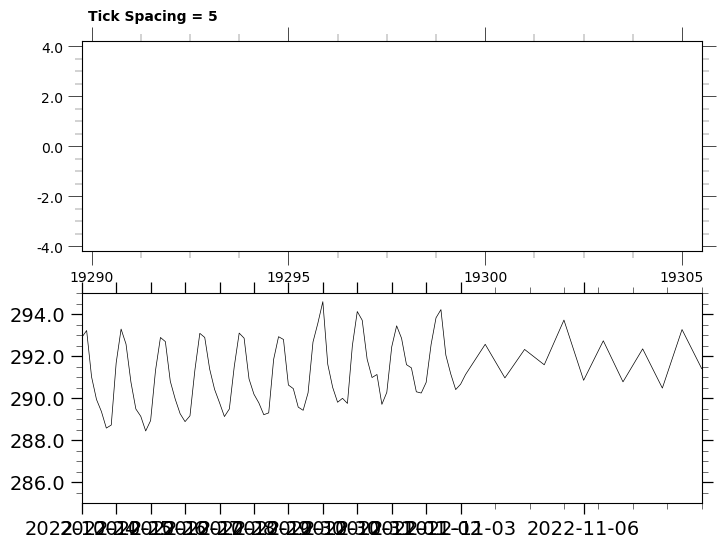

In [125]:
import pandas as pd
fechas = pd.to_datetime(data_2.time)

# Generate figure and set its size (width, height) in inches.
plt.figure(1, figsize=(8, 6))

# Make a subplot with major ticks that are multiples of 5.

# Create a subplot grid with two rows and one column (stacked subplots), and
# set the current plot context to the top subplot.
ax1 = plt.subplot(2, 1, 1)

# Format the tick labels. Use integers for the major ticks.
# For the minor ticks, use no labels; defaults to NullFormatter.
ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Set the major tick spacing.
major_tick_spacing = 5
ax1.xaxis.set_major_locator(MultipleLocator(major_tick_spacing))
spacingString = f'Tick Spacing = {major_tick_spacing}'

# Draw ticks on all sides of the plot.
plt.tick_params(which='both', top=True, right=True)

# Increase the length of the tick marks.
plt.tick_params(which='major', length=10.0, width=0.5)
plt.tick_params(which='minor', length=5.0, width=0.25)

# Set the minor tick spacing for X and Y axes.
ax1.xaxis.set_minor_locator(MultipleLocator(1.25))
ax1.yaxis.set_minor_locator(MultipleLocator(0.5))

# Add a descriptive string to the top left corner of the plot.
ax1.text(0.01, 1.1, spacingString, transform=ax1.transAxes, fontweight='bold')

# Plot data and set the X axis limits.
plt.plot(fechas, data_2.Temperature_isobaric, color='black', linewidth=0.5)

# Usa geocat.viz.util convenience function to set axes parameters without calling several matplotlib functions
# Set axes limits
gv.set_axes_limits_and_ticks(ax1, xlim=(fechas[0], fechas[-1]), ylim=(-4.2, 4.2))

# Make a subplot with major ticks that are set to explicit values and minor ticks that are multiples of 1.

# Set the current plot context to the bottom subplot.
ax2 = plt.subplot(2, 1, 2)

# Format the tick labels.
# For the minor ticks, use no labels; defaults to NullFormatter.
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.plot(fechas, data_2.Temperature_isobaric, color='black', linewidth=0.5)

gv.add_major_minor_ticks(ax2,
                             x_minor_per_major=5,
                             y_minor_per_major=3,
                             labelsize=14)
# Add minor and major tick lines for plot 3
gv.add_major_minor_ticks(ax2,
                         x_minor_per_major=1,
                         y_minor_per_major=4,
                         labelsize=14)
gv.set_axes_limits_and_ticks(ax2,
                             xlim=(fechas.min(), fechas.max()),
                             ylim=(285, 295),
                             xticks=fechas[::7],
                             xticklabels=fechas.date[::7])
                            #  yticks=np.arange(-4, 11, 2))

plt.show()

In [126]:
fechas

DatetimeIndex(['2022-10-24 18:00:00', '2022-10-24 21:00:00',
               '2022-10-25 00:00:00', '2022-10-25 03:00:00',
               '2022-10-25 06:00:00', '2022-10-25 09:00:00',
               '2022-10-25 12:00:00', '2022-10-25 15:00:00',
               '2022-10-25 18:00:00', '2022-10-25 21:00:00',
               '2022-10-26 00:00:00', '2022-10-26 03:00:00',
               '2022-10-26 06:00:00', '2022-10-26 09:00:00',
               '2022-10-26 12:00:00', '2022-10-26 15:00:00',
               '2022-10-26 18:00:00', '2022-10-26 21:00:00',
               '2022-10-27 00:00:00', '2022-10-27 03:00:00',
               '2022-10-27 06:00:00', '2022-10-27 09:00:00',
               '2022-10-27 12:00:00', '2022-10-27 15:00:00',
               '2022-10-27 18:00:00', '2022-10-27 21:00:00',
               '2022-10-28 00:00:00', '2022-10-28 03:00:00',
               '2022-10-28 06:00:00', '2022-10-28 09:00:00',
               '2022-10-28 12:00:00', '2022-10-28 15:00:00',
               '2022-10-